In [1]:
import os
os.chdir('..')
from speech import DataSetConfigurations
from speech import SPEECh
from speech import SPEEChGeneralConfiguration
from speech import Plotting
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
weekday_option = 'weekday'
data = DataSetConfigurations('Original16', ng=16)

In [4]:
import pickle

In [5]:
# Prepare weights for scenarios
data = DataSetConfigurations('Original16')
original_pg = pd.read_csv('Data/Original16/pg.csv')

counts_df = pd.DataFrame({'Original Weight': original_pg['pg'].values, 'AC Cluster Number': original_pg.index.values})
counts_df['Dend Cluster Number'] = 0
for i, j in data.cluster_reorder_dendtoac.items():
    counts_df.loc[counts_df[counts_df['AC Cluster Number'] == j].index, 'Dend Cluster Number'] = i
counts_df = counts_df.sort_values(by='Dend Cluster Number').reset_index(drop=True)

## Scenario 123
### Gives 0.67*0.9 weight to the combined set [3, 4, 5], etc., as labeled in the Dend cluster number.
rescales = {(0.67*0.9): [3, 4, 5], (0.67*0.1): [9], 0.33: [0, 1, 2, 6, 7, 8, 10, 11, 12, 13, 14, 15]}
counts_df['Scen1'] = counts_df['Original Weight'].copy()
for key, val in rescales.items():
    counts_df.loc[val, 'Scen1'] = counts_df.loc[val, 'Scen1'] * (key / sum(counts_df.loc[val, 'Scen1']))

goal_weight = 0.67  # What to increase timers to
key = 'Data/Original16/GMMs/weekday_home_'+str(data.cluster_reorder_dendtoac[3])+'.p'
joint_gmm = pickle.load(open(key, "rb"))
# Augmenting timers for cluster 3:
base_weights3 = {0: goal_weight}
key = 'Data/Original16/GMMs/weekday_home_'+str(data.cluster_reorder_dendtoac[4])+'.p'
joint_gmm = pickle.load(open(key, "rb"))
# Augmenting timers for cluster 4:
base_weights4 = {}
base_weights4[4] = goal_weight*(joint_gmm.weights_[4] / (joint_gmm.weights_[4] + joint_gmm.weights_[6]))
base_weights4[6] = goal_weight*(joint_gmm.weights_[6] / (joint_gmm.weights_[4] + joint_gmm.weights_[6]))
# Augmenting timers for cluster 5:
base_weights5 = {}
base_weights5[0] = goal_weight*(joint_gmm.weights_[0] / (joint_gmm.weights_[0] + joint_gmm.weights_[1]))
base_weights5[1] = goal_weight*(joint_gmm.weights_[1] / (joint_gmm.weights_[0] + joint_gmm.weights_[1]))


0.20580196380615234


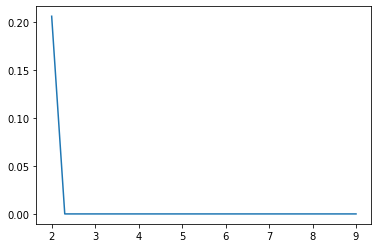

0.18214082717895508


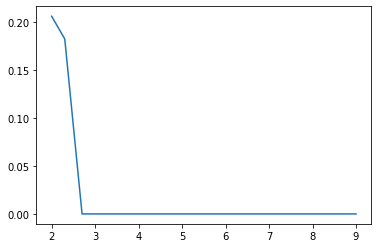

0.18720197677612305


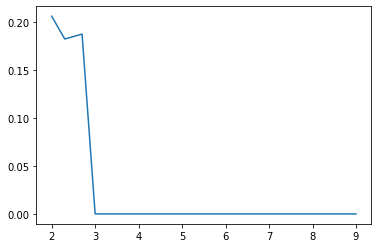

0.18861699104309082


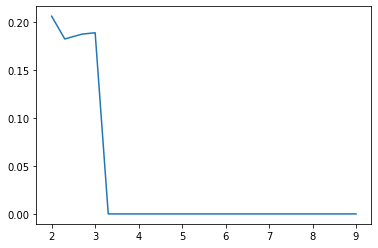

0.18848419189453125


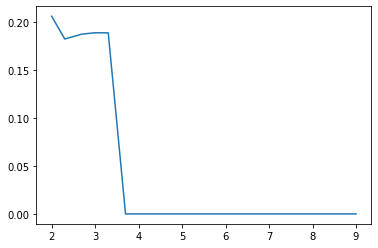

0.23328685760498047


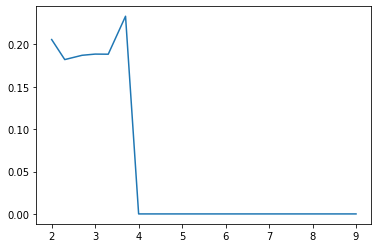

0.2520430088043213


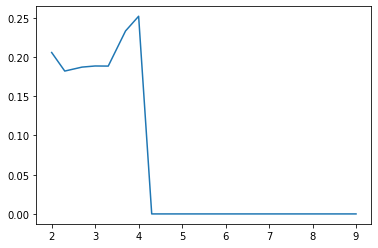

0.3088369369506836


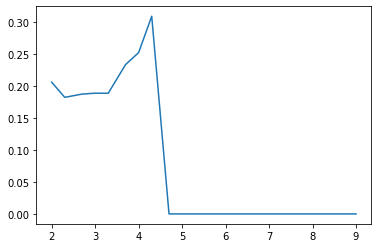

0.597785234451294


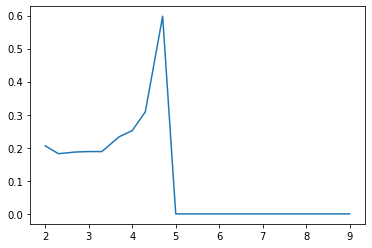

0.7609190940856934


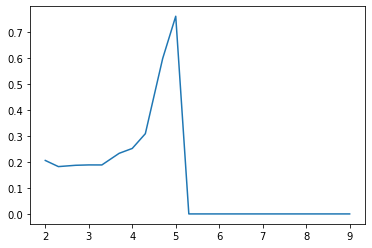

1.5041160583496094


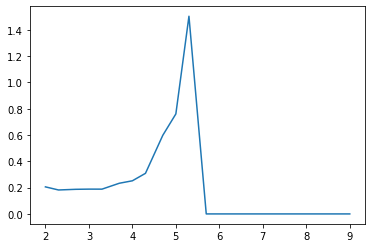

3.031871795654297


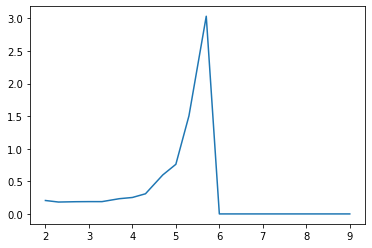

5.7934889793396


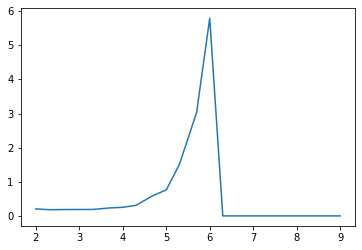

11.528223276138306


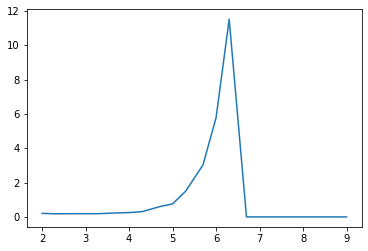

28.34013080596924


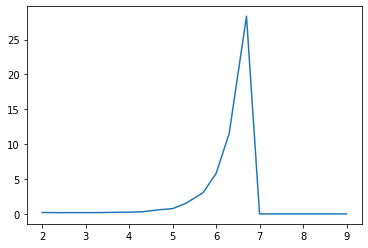

56.97126293182373


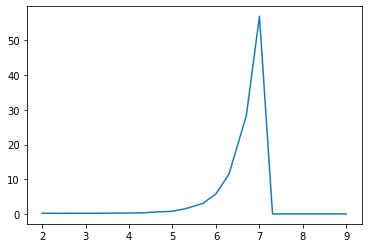

113.83375692367554


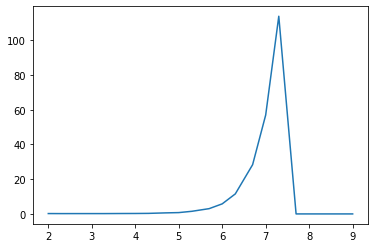

286.2913248538971


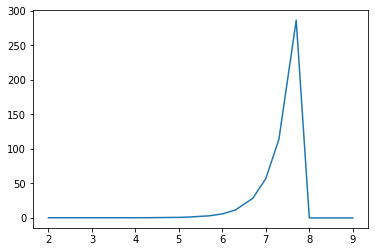

591.5616149902344


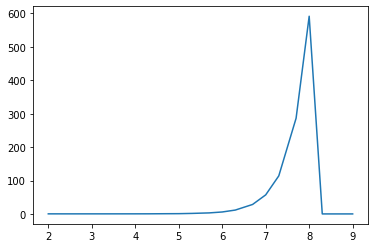

In [ ]:
nums = [1e2, 2e2, 5e2, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6, 2e6, 5e6, 1e7, 2e7, 5e7, 1e8, 2e8, 5e8, 1e9]
results = pd.DataFrame({'Time':np.zeros((len(nums))), 'Number of EVs':nums})
for i, total_evs in enumerate(nums):
    tic = time.time()
    model = SPEECh(data)
    config = SPEEChGeneralConfiguration(model)
    new_weights_pg = dict(zip(counts_df['AC Cluster Number'], counts_df['Scen1']))
    config.change_pg(new_weights=new_weights_pg)  # Adjust distribution over driver groups
    config.num_evs(total_evs)  # Input number of EVs in simulation
    config.groups()
    config.change_ps_zg(data.cluster_reorder_dendtoac[3], 'Home', 'weekday', base_weights3)
    config.change_ps_zg(data.cluster_reorder_dendtoac[4], 'Home', 'weekday', base_weights4)
    config.change_ps_zg(data.cluster_reorder_dendtoac[5], 'Home', 'weekday', base_weights5)
    config.run_all(weekday=weekday_option)
    toc = time.time()
    print(toc-tic)
    results.loc[i, 'Time'] = toc-tic
    
    plt.figure()
    plt.plot(np.log10(nums), results['Time'])
    plt.show()
    results.to_csv('ProcessingForPaper/time_results.csv')

In [ ]:
# total_evs = 1e9

# tic = time.time()
# model = SPEECh(data)
# config = SPEEChGeneralConfiguration(model)
# new_weights_pg = dict(zip(counts_df['AC Cluster Number'], counts_df['Scen1']))
# config.change_pg(new_weights=new_weights_pg)
# config.num_evs(total_evs)
# config.groups()
# config.change_ps_zg(data.cluster_reorder_dendtoac[3], 'Home', 'weekday', base_weights3)
# config.change_ps_zg(data.cluster_reorder_dendtoac[4], 'Home', 'weekday', base_weights4)
# config.change_ps_zg(data.cluster_reorder_dendtoac[5], 'Home', 'weekday', base_weights5)
# config.run_all(weekday=weekday_option)
# toc = time.time()
# print(toc-tic)
# results.loc[i+1, 'Time'] = toc-tic
# results.loc[i+1, 'Number of EVs'] = total_evs


In [21]:
(toc-tic)/60

83.2745994647344

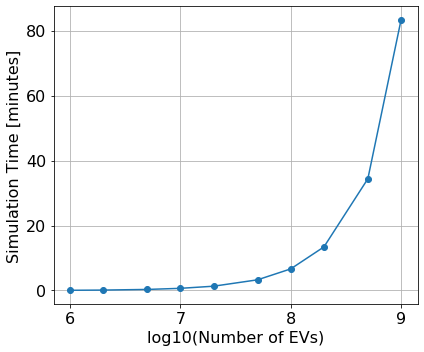

In [77]:
plt.figure(figsize=(6,5))
plt.plot(np.log10(results['Number of EVs'])[12:], (1/60)*results['Time'].values[12:], '-o')
plt.xlabel('log10(Number of EVs)', fontsize=16 )
plt.xticks([6, 7, 8, 9], fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Simulation Time [minutes]', fontsize=16 )
plt.grid()
plt.tight_layout()
plt.savefig('Figure10_simulationtime.pdf', bbox_inches='tight')
plt.show()

In [74]:
results.loc[12:].round(1)

,Time,Number of EVs
12,4.0,1.000000e+06
13,7.8,2.000000e+06
14,19.7,5.000000e+06
15,40.1,1.000000e+07
16,79.4,2.000000e+07
17,197.2,5.000000e+07
18,399.0,1.000000e+08
19,805.2,2.000000e+08
20,2062.4,5.000000e+08
21,4996.5,1.000000e+09


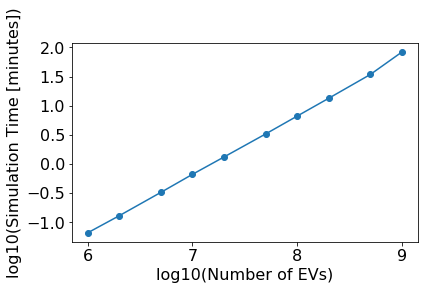

In [70]:
plt.figure(figsize=(6,(0.8*5)))
plt.plot(np.log10(results['Number of EVs'])[12:], np.log10((1/60)*results['Time'].values[12:]), '-o')
plt.xlabel('log10(Number of EVs)', fontsize=16 )
plt.xticks([6, 7, 8, 9], fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('log10(Simulation Time [minutes])', fontsize=16 )
plt.tight_layout()
# plt.savefig('Figure10_simulationtime.pdf', bbox_inches='tight')
plt.show()

In [82]:
def plot_single(self, load_segments_array, load_segments_dict, legend_subset=None, set_ylim=None, save_str=None, title=None, ylab=''):
    
    patterns = {'Residential L2': '/', 'MUD L2':'///', 'Workplace L2': '\\', 'Public L2': 'x', 'Public DCFC': '.'}
    x = (1/60)*np.arange(0, 1440)
    mark = np.zeros(np.shape(x))
    scaling = 1 / 1000
    unit = '[MW]'
    if np.max(scaling * np.sum(load_segments_array, axis=1)) > 1000:
        scaling = (1 / 1000) * (1 / 1000)
        unit = '[GW]'
    plt.figure(figsize=(6, 5))
    for key, val in load_segments_dict.items():
        plt.plot(x, scaling * (mark + val), color=self.speech.data.colours[key])
        if legend_subset is not None:
            if key in legend_subset:
                plt.fill_between(x, scaling * mark, scaling * (mark + val), hatch=patterns[key], facecolor=self.speech.data.colours[key], edgecolor='grey', label=key)
            else:
                plt.fill_between(x, scaling * mark, scaling * (mark + val), hatch=patterns[key], facecolor=self.speech.data.colours[key], edgecolor='grey')
        else:
            plt.fill_between(x, scaling * mark, scaling * (mark + val), label=key, hatch=patterns[key], facecolor=self.speech.data.colours[key], edgecolor='grey')
        mark += val
    plt.plot(x, scaling * mark, 'k')
    plt.legend(fontsize=14, loc='upper center', ncol=2)
    plt.xlim([0, np.max(x)])
    if set_ylim is None:
        plt.ylim([0, 1.1 * np.max(scaling * mark)])
    else:
        plt.ylim([0, set_ylim])
    plt.ylabel(ylab+unit, fontsize=17)
    plt.xlabel('Time of day [h]', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.gca().set_axisbelow(True)
    plt.grid(alpha=0.7)
    if title is not None:
        plt.set_title(title)
    if save_str is not None:
        plt.tight_layout()
        plt.savefig(save_str, bbox_inches='tight')
    plt.show()

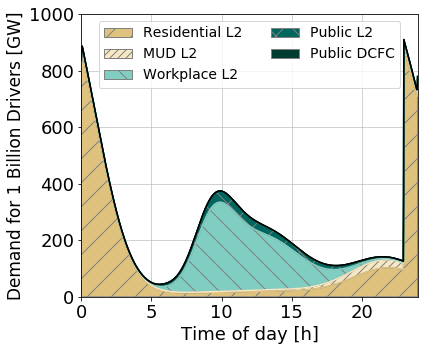

In [83]:
plotting = Plotting(model, config)
plot_single(plotting, config.total_load_segments, config.total_load_dict, save_str='Figure10b_1billion_new.pdf', ylab='Demand for 1 Billion Drivers ')

In [69]:
np.max(config.total_load_segments.sum(axis=1)[np.arange(int(22*60), int(24*60))])

910111554.3097641